<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/13_Multilayer_perceptrons/13_3_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 13: Multi-layer Perceptrons 

# 13.5  Optimization of Neural Network Models

Most learning models employing multi-layer perceptron units are often highly non-convex, a fact that for many years made them difficult to optimize properly. However in addition to many recently created ideas (starting in the early 2000s) that help significantly with the problem of tuning these models, for example the concept of *batch normalization*, we saw in Part I of this text that non-convexity is not by itself not necessarily prohibitive to proper parameter tuning. This is especially true with *first order methods*, i.e., methods derived from gradient descent (as detailed in Sections 3.6 - 3.9), which are the most popular optimization tools used to tune models employing multi-layer perceptrons. Indeed while they are universally applicable many of the practical advanced first order methods described there for extending the standard gradient descent algorithm to better deal with non-convexity were first developed by researchers aiming to improve standard optimization methods to better enable learning with multi-layer perceptrons.

In this Section broadly review the issue of non-convexity when employing multi-layer perceptrons, and highlight those tools introduced in Part I of the text that are especially relevant at optimizing such models.

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_13_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/13_Multilayer_perceptrons/chapter_13_datasets
    else:
        print('chapter_13_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_13_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/13_Multilayer_perceptrons/chapter_13_library
    else:
        print('chapter_13_library already cloned!')

    # clone images
    if not Path('chapter_13_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/13_Multilayer_perceptrons/chapter_13_images
    else:
        print('chapter_13_images already cloned!')

    # clone videos
    if not Path('chapter_13_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/13_Multilayer_perceptrons/chapter_13_videos
    else:
        print('chapter_13_videos already cloned!')

        
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_13_library') 

# backend file
import LS_sigmoid
from multilayer_med_library import superlearn_setup

# data path
import pickle
data_path_1 = 'chapter_13_datasets/2d_classification_data_v1_entropy.csv'
data_path_2 = 'chapter_13_datasets/MNIST_subset.pickle'

# image paths
image_path_1 = "chapter_13_images/bad_convex_comparison.png"

# video paths
video_path_1 = 'chapter_13_videos/animation_1.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from matplotlib import gridspec
import autograd.numpy as np
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Non-convexity and multi-layer perceptrons

Models employing multi-layer perceptron units are often considerably non-convex, however they often exhibit a variety of non-convexity that we can fairly easily deal with using advanced optimization methods. Indeed we saw simple exemplars of this behavior back in Sections 6.1.4 and 6.2.1, where we described the general behavior of the Least Squares cost when performing logistic regression when employing either the *sigmoid* or $\text{tanh}$ function. Interpreting the models used in both instances through the lens of multi-layer perceptrons, we can say that *both* are simple exemplars of a single hidden layer network model. For example, the Least Squares cost proposed in Section 6.1.4 consists of a model employing one unit of a single hidden layer network with sigmoid activation, i.e.,

\begin{equation}
\text{model}\left(x,\Theta\right) = \sigma\left(w_0 + w_1x \right).
\end{equation}

Here we can see that the weights of the final linear combination are *fixed*, with the bias set to zero and the weight touching $\sigma\left(\cdot\right)$ set to one. In Example 3 of Section 6.1.4 we plotted the surface of the Least Squares cost employing this network model using a simple toy dataset, which we show again in the figure below for convenience.

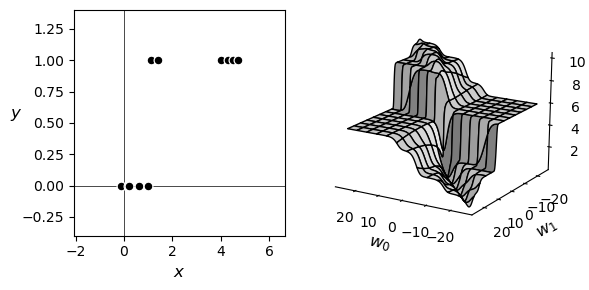

In [ ]:
# load data
data = np.loadtxt(data_path_1, delimiter = ',')

# create an instance of the visualizer and plot
demo = LS_sigmoid.Visualizer(data)
demo.plot_costs(viewmax = 25, view = [21,121])

Examining the general shape of the cost function in the right panel, firstly we can clearly see that it is non-convex. Several portions of the cost surface - on either side of the *long narrow valley* containing the cost's global minimum - *are almost completely flat*, likely containing *saddle points* that can halt most basic optimization schemes. As described in Chapter 4 (and Section 4.5 in particular), without serious adjustment second order methods struggle to minimize functions like this. These aspects of the non-convexity are also very problematic for the *basic* gradient descent algorithm - as detailed in Section 3.5. However gradient descent can be easily enhanced to deal with *precisely* these issues - as discussed in Sections 3.6 - 3.9.  Indeed both aspects of the non-convexity we see here -  both the *long narrow valley* and the *flat areas* potentially containing saddle points - were precisely the motivation for *momentum* (see Section 3.7) and *gradient normalization* (see Section 3.8) respectively.  Combining these two enhancements (see Section 3.9), in addition to mini-batch optimization (see Section 3.10), can further enhance gradient based methods so that they can more easily minimize cost functions such as this one.  Indeed back in Example 3 of Section 6.1.4 where this particular cost was first described, we show that the *normalized gradient descent* alone can properly minimize it.

In general cost functions employing neural network models have non-convex shapes that share the kinds of basic characteristics - long narrow valleys, flat areas, and many saddle points - seen in the example above. These sorts of non-convex functions can be effectively minimized in general using advanced optimization methods, the most popular of these being the sort of enhanced gradient descent algorithms described in the latter part of Chapter 3. Even when these cost functions have many *local minima* these tend to lie at a depth close to that of their global minima, and thus tend to provide similar performance if found via local optimization.  An artistic depiction of this sort of prototypical cost, the kind often experienced with neural network models, is shown in the left panel of the figure below.  This is starkly different than a kind of hypothetical non-convex cost - not often encountered with neural networks - whose global minima lie considerably lower than its local minima, like the one shown in the right panel of the figure below.  There are no enhancements one can make to any local optimization method to enable it to effectively deal with such a cost function, with the only practical salve being to make many optimization runs starting from random initial points to see if a global minima can be reached during some run.   

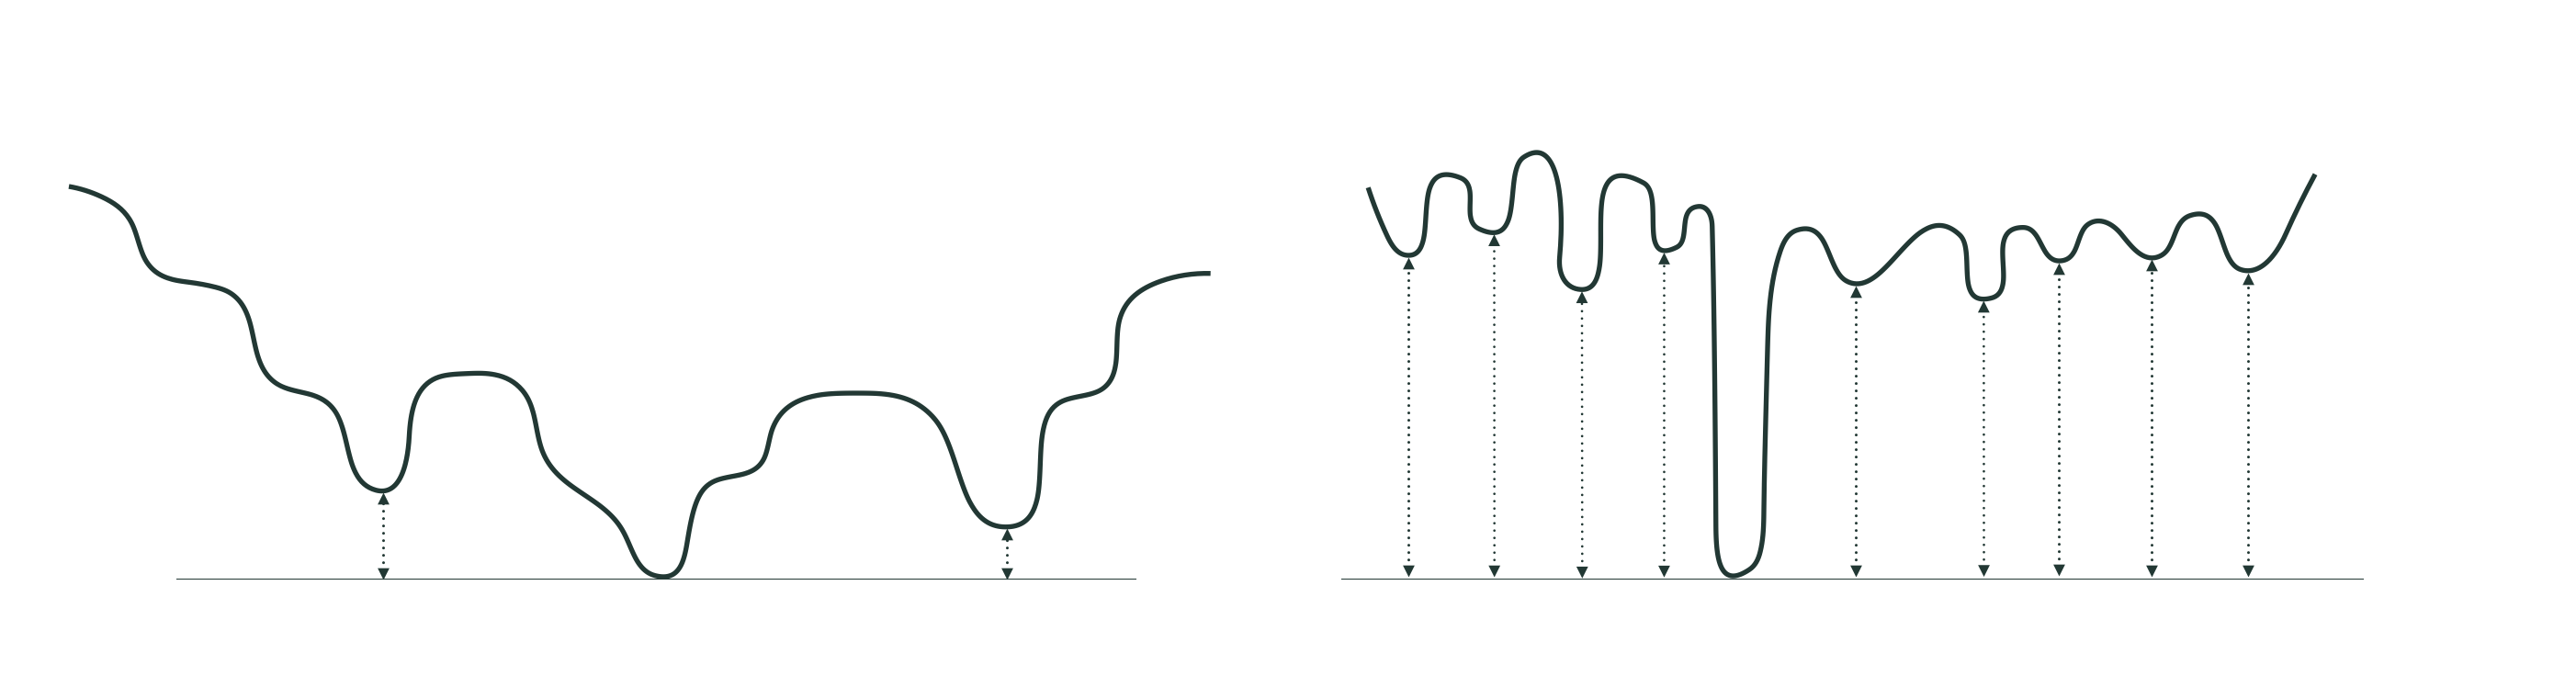

In [ ]:
Image(image_path_1)

<figure>
<figcaption> <strong>Figure 2:</strong> <em> (left panel) An artistic depiction of the sort of prototypical cost function seen when employing neural network models. (right panel) An artistic depiction of the sort of bad (difficult to properly minimize) non-convex cost rarely found when using neural networks.  See text for further details.  </em>
</figcaption>
</figure>

#### <span style="color:#a50e3e;">Example 1. </span>  Comparing standard gradient descent to 

In this Example we use $P = 50,000$ random datapoints from the MNIST dataset first detailed in Example 1 of Section 7.6, performing $C = 10$ class classification using a four hidden layer network with $10$ units per layer and a $\text{tanh}$ activation (these were chosen arbitrarily for the purposes of this example).  Here we compare the efficacy of two advanced optimization techniques - gradient normalization and mini-batch optimization - detailed in Sections 3.8 and 3.10 respectively - over the standard gradient descent algorithm in minimizing the associated Multiclass Softmax cost over this data.  

In the first figure below we show a comparison of the number of misclassifications during the first $10$ steps of a run of gradient descent and its normalized analog.  In the second figure we show the same results, only now compare the standard algorithm to a mini-batch version using a batch size of $200$.  Both advanced gradient algorithms drastically outperform the standard approach here.  Which advanced approach - or combination of them - works best in practice can vary from dataset to dataset.

In [ ]:
# load data
with open(data_path_2, "rb") as input_file:
    data = pickle.load(input_file)
    
x_sample = data[0]
y_sample = data[1] 

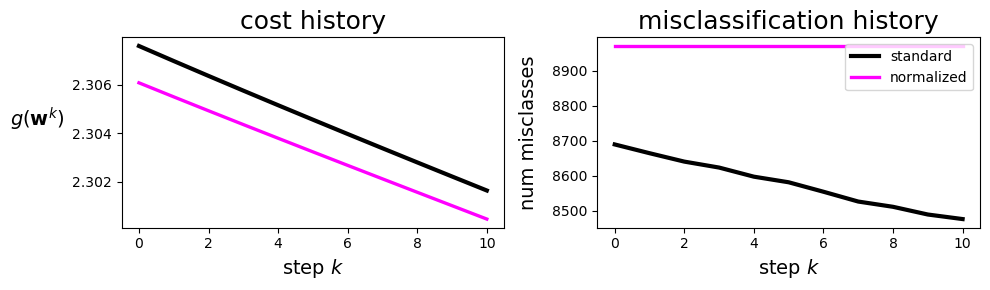

In [ ]:
# import the v1 library
mylib0 = superlearn_setup.Setup(x_sample,y_sample)

# choose features
layer_sizes = [784,10,10,10,10]

# choose features
mylib0.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh')

# choose normalizer
mylib0.choose_normalizer(name = 'standard')

# choose cost
mylib0.choose_cost(name = 'multiclass_softmax')

# fit an optimization
alpha = 10**(-1)
mylib0.fit(max_its = 10,alpha_choice = alpha)
# mylib0.fit(max_its = 10,alpha_choice = alpha,beta = 0.9)
mylib0.fit(max_its = 10,alpha_choice = alpha,normalize = True)
# mylib0.fit(max_its = 10,alpha_choice = alpha,optimizer = 'RMSprop')

# show histories
labels = ['standard','normalized']
mylib0.show_histories(labels = labels)

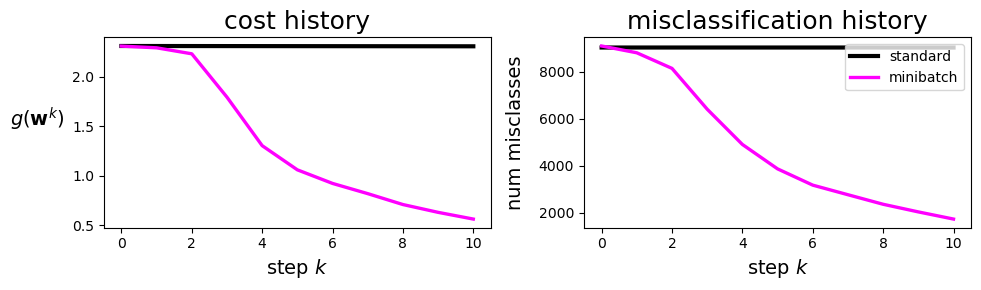

In [ ]:
# import the v1 library
mylib0 = superlearn_setup.Setup(x_sample,y_sample)

# choose features
layer_sizes = [784,10,10,10,10]

# choose features
mylib0.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'relu')

# choose normalizer
mylib0.choose_normalizer(name = 'standard')

# choose cost
mylib0.choose_cost(name = 'multiclass_softmax')

# fit an optimization
alpha = 10**(-1)
mylib0.fit(max_its = 10,alpha_choice = alpha)
mylib0.fit(max_its = 10,alpha_choice = alpha,batch_size = 200)
# mylib0.fit(max_its = 10,alpha_choice = alpha,normalize = True)
# mylib0.fit(max_its = 10,alpha_choice = alpha,optimizer = 'RMSprop')

# show histories
labels = ['standard','minibatch']
mylib0.show_histories(labels = labels)